# BDT

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

signal = pd.read_csv('.//data//500.csv', index_col=0)
background = pd.read_csv('.//data//background.csv', index_col=0)

signal.drop(["nTags", "MCChannelNumber", "mVHres"], axis=1, inplace=True)
background.drop(["nTags", "MCChannelNumber", "mVHres"], axis=1, inplace=True)

In [82]:
train_bkg, test_bkg = train_test_split(background, test_size=0.4, random_state=2)
train_signal, test_signal = train_test_split(signal, test_size=0.4, random_state=2)

train_y = len(train_bkg) * [0] + len(train_signal) * [1]
test_y = len(test_bkg) * [0] + len(test_signal) * [1]

train_x = pd.concat([train_bkg, train_signal], ignore_index=True)
test_x = pd.concat([test_bkg, test_signal], ignore_index=True)

train_x.drop(["weight"], axis=1, inplace=True)
test_x.drop(["weight"], axis=1, inplace=True)

print("Data has been split into test and train samples")
print("\tN(train) = ", len(train_x))
print("\tN(test)  = ", len(test_x))

Data has been split into test and train samples
	N(train) =  376022
	N(test)  =  250682


In [83]:
from sklearn.tree import DecisionTreeClassifier

print("\033[1mFit the decision tree\033[0m")
BDT_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", 
                             n_estimators=100, learning_rate=2).fit(train_x, train_y)

print("... now compute the decision tree score")
train_score = BDT_clf.score(train_x, train_y)
test_score  = BDT_clf.score(test_x, test_y)

print("\nDecision Tree Classifier Score is:")
print("\tTrain Score = ", train_score, " (This measure of performance is biased)")
print("\tTest Score  = {:5.4f}".format(test_score))
print("\tNumber of mis-classified test data = {:2.1f}".format((1-test_score)*len(test_x)))

Fit the decision tree
... now compute the decision tree score

Decision Tree Classifier Score is:
	Train Score =  0.776010446197297  (This measure of performance is biased)
	Test Score  = 0.7768
	Number of mis-classified test data = 55964.0


In [84]:
Decision_Function = BDT_clf.decision_function(test_x)
print('Output of Decision Function is:', Decision_Function) 

Output of Decision Function is: [-0.0168638   0.00226843 -0.03692952 ...  0.00226843  0.00226843
  0.00226843]


In [78]:
#plt.figure()
#plt.hist(Decision_Function)

In [95]:
X = np.concatenate((signal, background))
y = np.concatenate((np.ones(signal.shape[0]),
                    np.zeros(background.shape[0])))

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.4, random_state=2)
X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev, test_size=0.4, random_state=2)

In [96]:
BDT_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", 
                             n_estimators=300, learning_rate=2).fit(X_train, y_train)

<IPython.core.display.Javascript object>


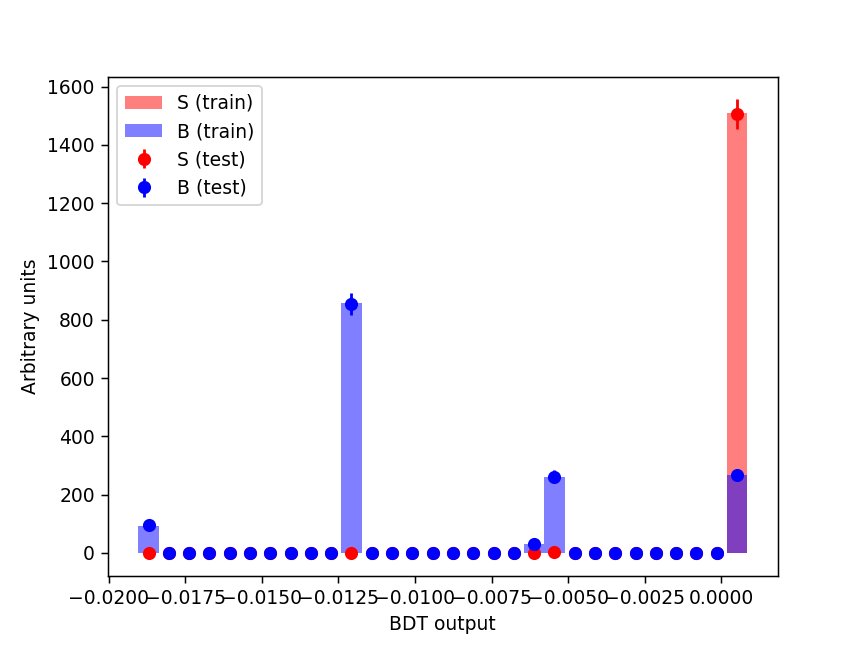

In [100]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
compare_train_test(BDT_clf, X_train, y_train, X_test, y_test)

In [56]:
# Total of four things: Training and Testing For signal and background (S and B

Classifier_training_S = BDT_clf.decision_function(X_train[y_train>0.5]).ravel()
Classifier_training_B = BDT_clf.decision_function(X_train[y_train<0.5]).ravel() 
Classifier_testing_S = BDT_clf.decision_function(X_test[y_test>0.5]).ravel()
Classifier_testing_B = BDT_clf.decision_function(X_test[y_test<0.5]).ravel() 

In [53]:
# This will be the min/max of our plots
c_max = 1
c_min = -1

# Get histograms of the classifiers
Histo_training_S = np.histogram(Classifier_training_S,bins=10,range=(c_min,c_max))
Histo_training_B = np.histogram(Classifier_training_B,bins=10,range=(c_min,c_max))
Histo_testing_S = np.histogram(Classifier_testing_S,bins=10,range=(c_min,c_max))
Histo_testing_B = np.histogram(Classifier_testing_B,bins=10,range=(c_min,c_max))

In [ ]:
# Lets get the min/max of the Histograms
AllHistos= [Histo_training_S,Histo_training_B,Histo_testing_S,Histo_testing_B]
h_max = max([histo[0].max() for histo in AllHistos])*1.2
h_min = max([histo[0].min() for histo in AllHistos])



<IPython.core.display.Javascript object>


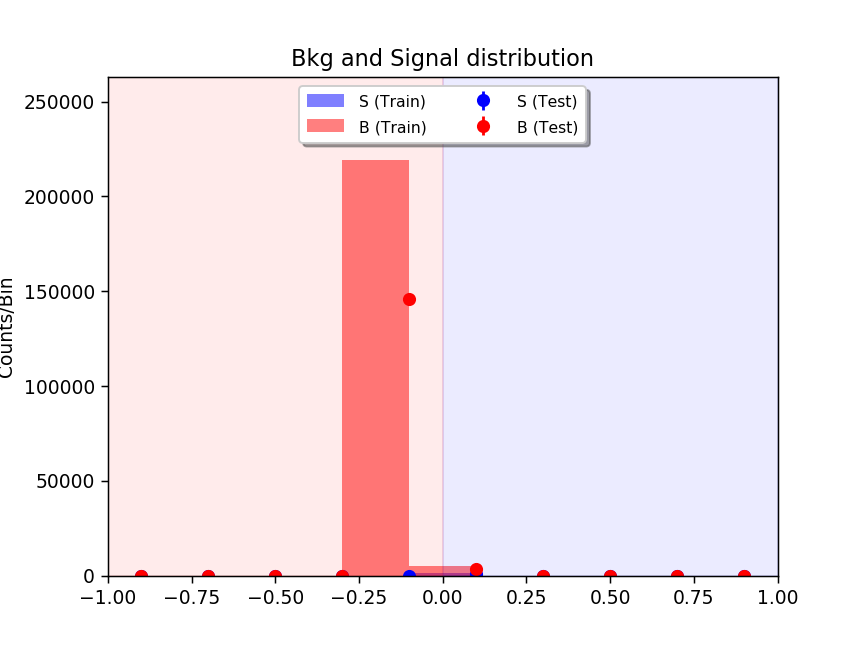

In [54]:
# Lets get the min/max of the Histograms
AllHistos= [Histo_training_S,Histo_training_B,Histo_testing_S,Histo_testing_B]
h_max = max([histo[0].max() for histo in AllHistos])*1.2
h_min = max([histo[0].min() for histo in AllHistos])
 
# Get the histogram properties (binning, widths, centers)
bin_edges = Histo_training_S[1]
bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
bin_widths = (bin_edges[1:] - bin_edges[:-1])
 
# To make error bar plots for the data, take the Poisson uncertainty sqrt(N)
#ErrorBar_testing_S = np.sqrt(Histo_testing_S[0])
ErrorBar_testing_B = np.sqrt(Histo_testing_B[0])
 
# Draw objects
ax1 = plt.subplot(111)
 
# Draw solid histograms for the training data
ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
ax1.bar(bin_centers-bin_widths/2.,Histo_training_B[0],facecolor='red',linewidth=0,width=bin_widths,label='B (Train)',alpha=0.5)
 
# # Draw error-bar histograms for the testing data
ax1.errorbar(bin_centers, Histo_testing_S[0], yerr=ErrorBar_testing_S, xerr=None, ecolor='blue',c='blue',fmt='o',label='S (Test)')
ax1.errorbar(bin_centers, Histo_testing_B[0], yerr=ErrorBar_testing_B, xerr=None, ecolor='red',c='red',fmt='o',label='B (Test)')
 
# Make a colorful backdrop to show the clasification regions in red and blue
ax1.axvspan(0.0, c_max, color='blue',alpha=0.08)
ax1.axvspan(c_min,0.0, color='red',alpha=0.08)
 
# Adjust the axis boundaries (just cosmetic)
ax1.axis([c_min, c_max, h_min, h_max])
 
# Make labels and title
#%matplotlib notebook
plt.title("Bkg and Signal distribution")
#plt.xlabel("BDT")
plt.ylabel("Counts/Bin")
 
# Make legend with smalll font
legend = ax1.legend(loc='upper center', shadow=True,ncol=2)
for alabel in legend.get_texts():
            alabel.set_fontsize('small')